In [573]:
import numpy as np
from scipy.spatial import Delaunay
import cv2
import dlib
from ffmpy3 import FFmpeg

import matplotlib.pyplot as plt
from matplotlib import path

import os

%matplotlib inline

**Requirements:**

pip install ffmpy3

pip install dlib

## 1 Correspondence

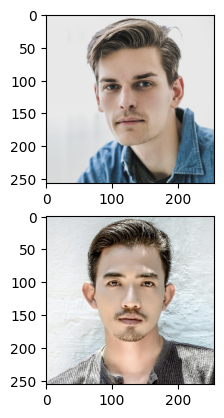

In [538]:
src_image = plt.imread('portrait0.jpeg')
dst_image = plt.imread('portrait1.jpeg')

src_image = cv2.resize(src_image, (256, 256))
dst_image = cv2.resize(dst_image, (256, 256))

fig, ax = plt.subplots(2, 1)
ax[0].imshow(src_image)
ax[1].imshow(dst_image)


In [539]:
def getShapePoints(img, add_corner=True):

    height, width, c = img.shape

    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    rects = detector(img, 0)
    shape = predictor(img, rects.pop())
    
    shape_array = []
    if add_corner:
        shape_array = [[0, 0], [0, width], [height, 0], [height, width]]
    for i in range(68):
        pt = shape.part(i)
        shape_array.append([pt.x, pt.y])
    shape_array = np.array(shape_array)

    return shape_array

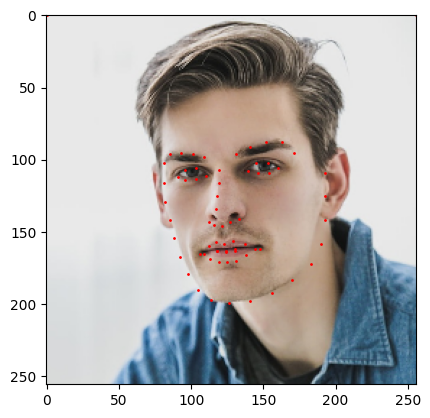

In [540]:
shape_src = getShapePoints(src_image)
plt.plot(shape_src[:, 0], shape_src[:, 1], 'ro', markersize=1)
plt.imshow(src_image)
plt.show()

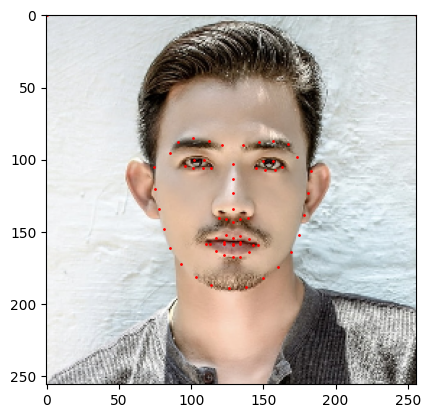

In [541]:
shape_dst = getShapePoints(dst_image)
plt.plot(shape_dst[:, 0], shape_dst[:, 1], 'ro', markersize=1)
plt.imshow(dst_image)
plt.show()

## 2 Mesh

In [542]:
def getDelaunayTriMesh(points):
    return Delaunay(points).simplices

(136, 3)


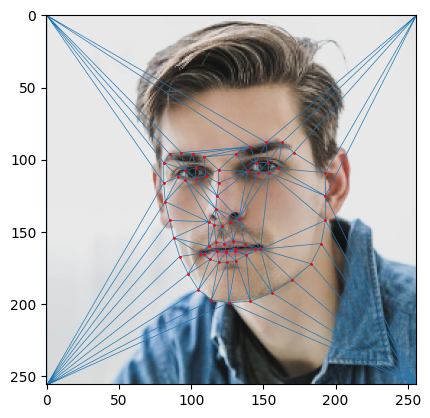

In [543]:
tri_src = getDelaunayTriMesh(shape_src)
print(tri_src.shape)
plt.triplot(shape_src[:, 0], shape_src[:, 1], tri_src, linewidth=0.5)
plt.plot(shape_src[:,0], shape_src[:,1], 'ro', markersize=1) 
plt.imshow(src_image)
plt.show()

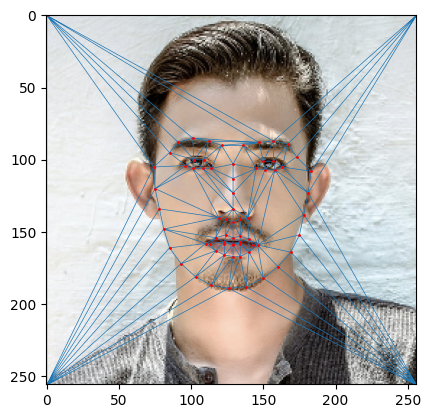

In [544]:
plt.triplot(shape_dst[:, 0], shape_dst[:, 1], tri_src, linewidth=0.5)
plt.plot(shape_dst[:,0], shape_dst[:,1], 'ro', markersize=1) 
plt.imshow(dst_image)
plt.show()

## 3 Blending with a mesh

In [545]:
def calAffineMat(tri_src, tri_dst):

    assert tri_src.shape == (3, 2) and tri_dst.shape == (3, 2)

    tri_src = np.hstack((tri_src, np.array([[1],[1],[1]]))).T
    tri_dst = np.hstack((tri_dst, np.array([[1],[1],[1]]))).T

    affineMat = tri_dst @ np.linalg.inv(tri_src)
    affineMat[2] = np.array([0., 0., 1.])

    return affineMat

In [546]:
def bilinearInterpolation(im, points):

    # Only accepts single channel image (M x N)

    im = np.pad(im, ((0,1),(0,1)), 'edge')

    Q11 = np.floor(points).astype(np.uint32)
    Q12 = Q11 + np.array([0, 1])
    Q22 = Q11 + np.array([1, 1])
    Q21 = Q11 + np.array([1, 0])
    
    a = im[Q11[:, 0], Q11[:, 1]]
    b = im[Q21[:, 0], Q21[:, 1]]
    c = im[Q12[:, 0], Q12[:, 1]]
    d = im[Q22[:, 0], Q22[:, 1]]
    e = np.stack((a, b), axis=1)
    f = np.stack((c, d), axis=1)

    fQ = np.stack((e, f), axis=2)

    x = np.stack((Q21[:, 0] - points[:, 0], points[:, 0] - Q11[:, 0]), axis=1)[:, np.newaxis, :]
    y = np.stack((Q12[:, 1] - points[:, 1], points[:, 1] - Q11[:, 1]), axis=1)[:, :, np.newaxis]
    s1 = np.einsum('ijk,ikl->ijl', fQ, y, optimize=True)
    s2 = np.einsum('ijk,ikl->ijl', x, s1, optimize=True)

    return s2.flatten()

In [547]:
def inTriangle(points, triangle):
    
    # assert points.ndim == 2 and triangle.shape == (3, 2)
    return path.Path(triangle).contains_points(points, radius=1e-8)

In [548]:
def calBetweenImage(im_src, points_src, im_dst, points_dst, w, tri_mesh):

    height, width = im_src.shape[:2]

    points_bet = (1 - w) * points_src + w * points_dst

    im_bet = np.zeros(im_src.shape)

    X, Y = np.meshgrid(np.linspace(0, height - 1, height), np.linspace(0, width - 1, width))
    X = X[:, :, np.newaxis]
    Y = Y[:, :, np.newaxis]
    Z = np.ones((height * width, 1))
    cor = np.concatenate((Y, X), axis=2)
    cor_flat = cor.reshape((height * width, 2))
    tri_idx = np.zeros((height * width,)) + tri_mesh.shape[0]
    unit_affmat = np.array([
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
    ])
    zero_affmat = np.array([
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
    ])

    b2s = []
    b2d = []

    idx = 0
    for tri in tri_mesh:
        tri_is_in = inTriangle(cor_flat, points_bet[tri])
  
        tri_idx[tri_is_in] = idx
        b2s.append(calAffineMat(points_bet[tri], points_src[tri]))
        b2d.append(calAffineMat(points_bet[tri], points_dst[tri]))

        idx += 1

    b2s.append(unit_affmat)
    b2d.append(unit_affmat)

    #tri_idx = tri_idx.reshape((height, width)).astype(np.int32)
    tri_idx = tri_idx.astype(np.int32)
    b2s = np.array(b2s)[tri_idx]
    b2d = np.array(b2d)[tri_idx]

    cor_flat = np.concatenate((cor_flat, Z), axis=1)
    pins = np.einsum('ijk,ikl->ij', b2s, cor_flat[:, :, np.newaxis], optimize=True)[:, :2]
    pind = np.einsum('ijk,ikl->ij', b2d, cor_flat[:, :, np.newaxis], optimize=True)[:, :2]

    im_bet = np.zeros(im_src.shape)
    im_bet[:, :, 0] = ((1 - w) * bilinearInterpolation(im_src[:, :, 0], pins) + w * bilinearInterpolation(im_dst[:, :, 0], pind)).reshape((height, width))
    im_bet[:, :, 1] = ((1 - w) * bilinearInterpolation(im_src[:, :, 1], pins) + w * bilinearInterpolation(im_dst[:, :, 1], pind)).reshape((height, width))
    im_bet[:, :, 2] = ((1 - w) * bilinearInterpolation(im_src[:, :, 2], pins) + w * bilinearInterpolation(im_dst[:, :, 2], pind)).reshape((height, width))

    return im_bet.astype(np.uint8)
    


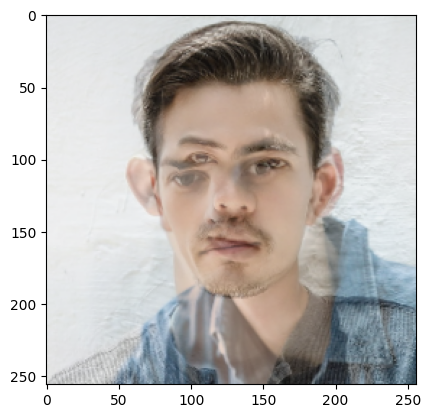

In [568]:
im_bet = calBetweenImage(src_image, shape_src, dst_image, shape_dst, 0.5, tri_src)
plt.imshow(im_bet)


## 4 Blending without a mesh

### Affine Version

In [550]:
def calBetweenImage_affine(im_src, points_src, im_dst, points_dst, weight, alpha):

    height, width = im_src.shape[:2]
    im_bet = np.zeros(im_dst.shape)

    # The formula can't deal with weight=1, because d(x) is irrelevant with weight.
    # E(x + d(x)) is actually a fixed image.
    if weight == 1:
        return im_dst

    for h in range(height):
        for w in range(width):
            is_fea = False
            for ps, pd in zip(points_src, points_dst):
                if ps[0] == h and ps[1] == w:
                    is_fea = True
                    im_bet[h, w] = (1 - weight) * im_src[h, w] + weight * im_dst[pd[0], pd[1]]
                    break
            if is_fea:
                continue
            x = np.array([h, w])
            sk = np.sum(1 / alpha / np.square(np.linalg.norm(x - points_src, axis=1)))
            dk = 1. * (points_src - points_dst)
            kd = 1 / alpha / np.square(np.linalg.norm(x - points_src, axis=1))
            dk[:, 0] *= kd
            dk[:, 1] *= kd
            dk = np.rint(np.sum(dk, axis=0) / sk)
            hd = np.clip(h - dk[0], 0, height - 1).astype(np.int32)
            wd = np.clip(w - dk[1], 0, width  - 1).astype(np.int32)
            im_bet[h, w] = (1 - weight) * im_src[h, w] + weight * im_dst[hd, wd]
    
    return im_bet.astype(np.uint8)


In [581]:
shape_src_nc = getShapePoints(src_image, False)
shape_dst_nc = getShapePoints(dst_image, False)
im_bet = calBetweenImage_affine(src_image, shape_src, dst_image, shape_dst, 0.5, 1)

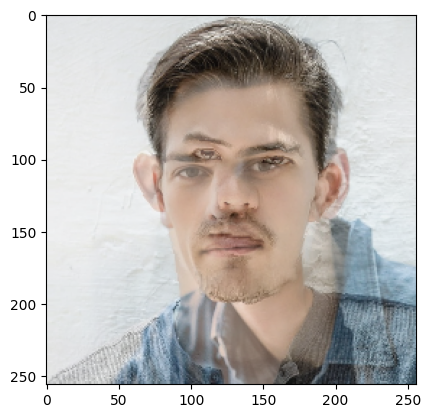

In [582]:
plt.imshow(im_bet)

### Rigid Version

In [553]:
def calWeight(pis, v, alpha=1.):
    """
    pis:    control points on origin image
    v:      a point on origin image
    alpha:  a param

    return: nx1
    """

    return 1 / np.power(np.linalg.norm(pis - v, axis=1), 2 * alpha)

In [554]:
def calPStar(ctrl_points, ps, v, alpha=1.):
    """
    ctrl_points: control points on corresponded image
    ps:          control points on origin image
    v:           a point on origin image
    alpha:       a param

    return: 2x1
    """
    
    wis = calWeight(ps, v, alpha)
    cp = np.zeros(ctrl_points.shape)
    cp[:, 0] = ctrl_points[:, 0] * wis
    cp[:, 1] = ctrl_points[:, 1] * wis

    return np.sum(cp, axis=0) / np.sum(wis)

In [555]:
def calPiHat(pis, p_star):
    """
    return: nx2
    """
    return pis - p_star

In [556]:
def calAffinedImage(im_src, points_src, im_dst, points_dst, alpha=1.):

    height, width = im_src.shape[:2]
    im_aff = np.zeros(im_src.shape)

    for h in range(height):
        for w in range(width):
            v = np.array([h, w]) * 1.
            wis = calWeight(points_src, v, alpha)
            p_star = calPStar(points_src, points_src, v, alpha)
            p_hat_is = points_src - p_star
            p_hat_it = np.zeros(p_hat_is.shape)
            p_hat_it[:, 0], p_hat_it[:, 1] = p_hat_is[:, 1], -p_hat_is[:, 0]
            p_mat = np.stack((p_hat_is, p_hat_it), axis=1)
            v_pstar = v - p_star
            v_mat = np.array([
                [v_pstar[0], v_pstar[1]],
                [v_pstar[1], -v_pstar[0]],
            ]).T
            Ai = p_mat @ v_mat
            Ai[:, 0, 0] *= wis
            Ai[:, 0, 1] *= wis
            Ai[:, 1, 0] *= wis
            Ai[:, 1, 1] *= wis
            q_star = calPStar(points_dst, points_src, v, alpha)
            q_hat_is = points_dst - q_star
            frv_d = np.einsum('ik,ikl->il', q_hat_is, Ai, optimize=True)
            frv_d = np.sum(frv_d, axis=0)
            frv = np.linalg.norm(v_pstar) * frv_d / np.linalg.norm(frv_d) + q_star
            frv = np.rint(frv)
            hd = np.clip(frv[0], 0, height - 1).astype(np.int32)
            wd = np.clip(frv[1], 0, width  - 1).astype(np.int32)
            im_aff[h, w] = im_dst[hd, wd]
            
    return im_aff.astype(np.uint8)

In [557]:
def calBetweenImage_rigid(im_src, points_src, im_dst, points_dst, weight, alpha=1.):

    height, width = im_src.shape[:2]
    im_bet = np.zeros(im_dst.shape)

    points_bet = ((1 - weight) * points_src + weight * points_dst) + 0.001

    im_src_rigid = calAffinedImage(im_src, points_bet, im_src, points_src)
    im_dst_rigid = calAffinedImage(im_src, points_bet, im_dst, points_dst)

    im_bet = (1 - weight) * im_src_rigid + weight * im_dst_rigid
    
    return im_bet.astype(np.uint8)

In [566]:
im_bet = calBetweenImage_rigid(src_image, shape_src, dst_image, shape_dst, 0.5, alpha=1.)

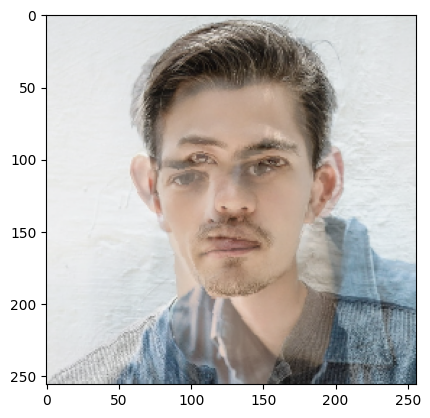

In [567]:
plt.imshow(im_bet)

## 5 Capture

In [562]:
capture_mesh_path   = 'capture_mesh'
capture_affine_path = 'capture_affine'
capture_rigid_path  = 'capture_rigid'

os.mkdir(capture_mesh_path)
os.mkdir(capture_affine_path)
os.mkdir(capture_rigid_path)

In [569]:
def captureToImage(func, param, save_dir, im_num):

    for i in range(im_num + 1):
        filename = '%d.png' % i
        weight = i / im_num
        param[4] = weight
        im = func(*param)
        plt.imsave(os.path.join(save_dir, filename), im)

In [588]:
captureToImage(calBetweenImage, [src_image, shape_src, dst_image, shape_dst, 0, tri_src], capture_mesh_path, 100)
try:
    os.remove(os.path.join(capture_mesh_path, 'capture.mp4'))
except:
    pass
ffin = FFmpeg(inputs={'%s' % os.path.join(capture_mesh_path, '%d.png'): '-f image2 -r 50'}, outputs={'%s' % os.path.join(capture_mesh_path, 'capture.mp4'): None})
ffin.run()

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple LLVM version 10.0.1 (clang-1001.0.46.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.1.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/adoptopenjdk-11.0.2.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/adoptopenjdk-11.0.2.jdk/Contents/Home/include/darwin' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-videotoo

(None, None)

In [589]:
captureToImage(calBetweenImage_affine, [src_image, shape_src, dst_image, shape_dst, 0, 1], capture_affine_path, 50)
try:
    os.remove(os.path.join(capture_affine_path, 'capture.mp4'))
except:
    pass
ffin = FFmpeg(inputs={'%s' % os.path.join(capture_affine_path, '%d.png'): '-f image2 -r 25'}, outputs={'%s' % os.path.join(capture_affine_path, 'capture.mp4'): None})
ffin.run()

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple LLVM version 10.0.1 (clang-1001.0.46.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.1.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/adoptopenjdk-11.0.2.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/adoptopenjdk-11.0.2.jdk/Contents/Home/include/darwin' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-videotoo

(None, None)

In [590]:
captureToImage(calBetweenImage_rigid, [src_image, shape_src, dst_image, shape_dst, 0, 1], capture_rigid_path, 50)
try:
    os.remove(os.path.join(capture_rigid_path, 'capture.mp4'))
except:
    pass
ffin = FFmpeg(inputs={'%s' % os.path.join(capture_rigid_path, '%d.png'): '-f image2 -r 25'}, outputs={'%s' % os.path.join(capture_rigid_path, 'capture.mp4'): None})
ffin.run()

ffmpeg version 4.1.3 Copyright (c) 2000-2019 the FFmpeg developers
  built with Apple LLVM version 10.0.1 (clang-1001.0.46.4)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.1.3_1 --enable-shared --enable-pthreads --enable-version3 --enable-hardcoded-tables --enable-avresample --cc=clang --host-cflags='-I/Library/Java/JavaVirtualMachines/adoptopenjdk-11.0.2.jdk/Contents/Home/include -I/Library/Java/JavaVirtualMachines/adoptopenjdk-11.0.2.jdk/Contents/Home/include/darwin' --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libmp3lame --enable-libopus --enable-librubberband --enable-libsnappy --enable-libtesseract --enable-libtheora --enable-libvorbis --enable-libvpx --enable-libx264 --enable-libx265 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-librtmp --enable-libspeex --enable-videotoo

(None, None)